In [13]:
import rasterio
from rasterio.plot import show
from rasterstats import zonal_stats
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline

maps = ['no2', 'nox', 'pm10', 'pm25']
rasters = {}
for map_name in maps:
    rasters[map_name] = rasterio.open(f"data/{map_name}.tif")

In [14]:
gdf = gpd.read_file("data/CBS Utrecht/CBS_2018_Utrecht.shp")
gdf

,PC4,INWONER,MAN,VROUW,INW_014,INW_1524,INW_2544,INW_4564,INW_65PL,GEBOORTE,...,AV20ZIEK_E,AFS_ZIEK_I,AV5_ZIEK_I,AV10ZIEK_I,AV20ZIEK_I,AFS_APOTH,AFS_HAPOST,OAD,STED,geometry
0,3705,9520,4575,4945,1765,1500,2245,2560,1445,90,...,9.0,2.4,1.4,4.6,14.0,0.9,2.6,1995,2,"MULTIPOLYGON (((143788.215 456025.039, 143795...."
1,3766,7345,3545,3800,1185,795,1415,2280,1665,60,...,8.0,6.8,0.0,2.0,12.6,0.8,7.9,1758,2,"POLYGON ((147540.710 465074.677, 147540.719 46..."
2,3768,6020,2945,3070,990,645,1045,1835,1505,55,...,8.0,5.8,0.1,2.1,14.0,0.9,5.8,786,4,"MULTIPOLYGON (((152044.730 464967.718, 152043...."
3,3992,6110,3035,3075,920,755,1165,2280,990,45,...,6.0,2.8,1.0,3.7,11.0,1.6,2.8,1509,2,"POLYGON ((139805.752 449557.022, 139804.801 44..."
4,1105,540,260,280,25,365,105,40,10,-99997,...,9.0,0.9,2.0,4.9,14.0,0.9,0.9,1499,3,"MULTIPOLYGON (((124916.031 476865.196, 124918...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,6718,8255,4175,4085,2030,1120,2290,2095,725,125,...,1.1,5.5,0.3,2.0,5.2,3.4,5.5,875,4,"MULTIPOLYGON (((168911.887 449464.256, 168911...."
299,6721,15030,7310,7715,2285,1800,2775,4365,3800,115,...,1.9,4.1,1.5,2.1,5.9,1.3,4.4,1167,3,"MULTIPOLYGON (((168798.818 446915.367, 168801...."
300,6741,13490,6715,6775,2635,1890,2855,3535,2580,195,...,1.0,5.9,0.2,2.8,6.7,2.2,8.3,569,4,"MULTIPOLYGON (((166356.060 457000.000, 166356...."
301,6744,3620,1860,1765,870,615,820,840,475,55,...,1.0,6.0,0.1,2.9,6.1,1.0,8.7,240,5,"MULTIPOLYGON (((166921.248 453862.628, 166925...."


In [15]:
areas_vector = gdf[['PC4', 'geometry']]
areas_vector

,PC4,geometry
0,3705,"MULTIPOLYGON (((143788.215 456025.039, 143795...."
1,3766,"POLYGON ((147540.710 465074.677, 147540.719 46..."
2,3768,"MULTIPOLYGON (((152044.730 464967.718, 152043...."
3,3992,"POLYGON ((139805.752 449557.022, 139804.801 44..."
4,1105,"MULTIPOLYGON (((124916.031 476865.196, 124918...."
...,...,...
298,6718,"MULTIPOLYGON (((168911.887 449464.256, 168911...."
299,6721,"MULTIPOLYGON (((168798.818 446915.367, 168801...."
300,6741,"MULTIPOLYGON (((166356.060 457000.000, 166356...."
301,6744,"MULTIPOLYGON (((166921.248 453862.628, 166925...."


<AxesSubplot:>

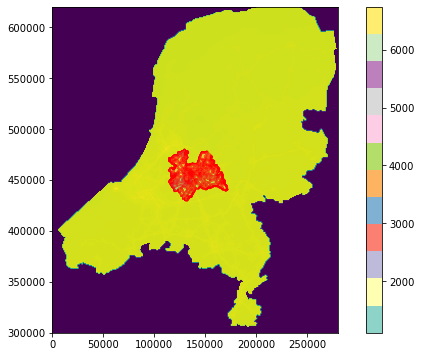

In [16]:
fig, ax = plt.subplots(1,1, figsize = (10,6))
areas_vector.plot(ax=ax, edgecolor='red', linewidth=2, column='PC4', cmap='Set3', alpha=0.4, legend=True)
show((rasters['nox'], 1), ax=ax)

In [17]:
for map_name in maps:
    print('Starting')
    stats = zonal_stats(areas_vector, rasters[map_name].read(1), affine=rasters[map_name].transform,
                        stats=['mean'],
                        nodata=-99997,
                        all_touched=True,
                        geojson_out=True)
    print(f'Done with {map_name}')

    gdf_inter = gpd.GeoDataFrame.from_features(stats)
    gdf[f'{map_name}_mean'] = gdf_inter['mean']

Starting
Done with no2
Starting
Done with nox
Starting
Done with pm10
Starting
Done with pm25


In [18]:
maps

['no2', 'nox', 'pm10', 'pm25']

<AxesSubplot:>

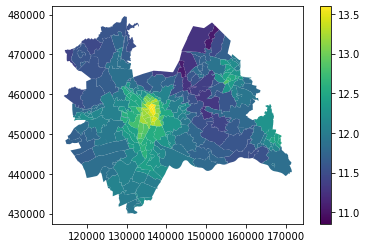

In [19]:
gdf.plot(column='pm25_mean', legend=True)

In [20]:
import numpy as np
gdf[gdf == -99997] = np.nan

In [21]:
# these variables were selected using random forest importance criteria
gdf = gdf.dropna(subset=['G_GAS_WON', 'G_ELEK_WON', 'P_NL_ACHTG', 'STED', 'INW_2544', 'WOZWONING', 'OAD', 'P_HINK_HH'])

In [22]:
gdf.to_file("data_utrecht/output-dropna.shp")
gdf.to_file("data_utrecht/output-dropna.geojson", driver='GeoJSON')
gdf.to_file("data_utrecht/output-dropna.gpkg", driver="GPKG")

/opt/homebrew/Caskroom/miniforge/base/envs/ssml/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/homebrew/Caskroom/miniforge/base/envs/ssml/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/homebrew/Caskroom/miniforge/base/envs/ssml/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [23]:
gdf

,PC4,INWONER,MAN,VROUW,INW_014,INW_1524,INW_2544,INW_4564,INW_65PL,GEBOORTE,...,AV20ZIEK_I,AFS_APOTH,AFS_HAPOST,OAD,STED,geometry,no2_mean,nox_mean,pm10_mean,pm25_mean
0,3705,9520,4575,4945,1765.0,1500.0,2245.0,2560.0,1445.0,90.0,...,14.0,0.9,2.6,1995,2,"MULTIPOLYGON (((143788.215 456025.039, 143795....",19.016667,24.544444,19.442222,12.121111
1,3766,7345,3545,3800,1185.0,795.0,1415.0,2280.0,1665.0,60.0,...,12.6,0.8,7.9,1758,2,"POLYGON ((147540.710 465074.677, 147540.719 46...",14.987143,17.800000,18.680714,11.558571
2,3768,6020,2945,3070,990.0,645.0,1045.0,1835.0,1505.0,55.0,...,14.0,0.9,5.8,786,4,"MULTIPOLYGON (((152044.730 464967.718, 152043....",14.938286,17.945714,18.426571,11.358571
3,3992,6110,3035,3075,920.0,755.0,1165.0,2280.0,990.0,45.0,...,11.0,1.6,2.8,1509,2,"POLYGON ((139805.752 449557.022, 139804.801 44...",24.327333,34.240000,20.018667,12.585333
5,1106,18095,8715,9380,3260.0,2400.0,4615.0,5210.0,2605.0,190.0,...,14.8,0.9,2.3,2411,2,"MULTIPOLYGON (((128748.347 478740.694, 128749....",16.670000,19.600000,18.780000,11.530000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,6718,8255,4175,4085,2030.0,1120.0,2290.0,2095.0,725.0,125.0,...,5.2,3.4,5.5,875,4,"MULTIPOLYGON (((168911.887 449464.256, 168911....",20.840000,28.800000,20.330000,12.486667
299,6721,15030,7310,7715,2285.0,1800.0,2775.0,4365.0,3800.0,115.0,...,5.9,1.3,4.4,1167,3,"MULTIPOLYGON (((168798.818 446915.367, 168801....",15.356667,19.600000,19.710000,12.020000
300,6741,13490,6715,6775,2635.0,1890.0,2855.0,3535.0,2580.0,195.0,...,6.7,2.2,8.3,569,4,"MULTIPOLYGON (((166356.060 457000.000, 166356....",15.170000,19.316667,22.848333,12.433333
301,6744,3620,1860,1765,870.0,615.0,820.0,840.0,475.0,55.0,...,6.1,1.0,8.7,240,5,"MULTIPOLYGON (((166921.248 453862.628, 166925....",16.917500,22.125000,20.692500,12.277500
